In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Load the dataset
df = pd.read_csv('../Data/CasusData.csv')

### BigO-Notation
#### Kort overzicht van de gebruikte sleutelsvoor de Time Complexity indicatoren:
- \(N\): Aantal datapunten in het dataset
  - Het totale aantal datapunten in het dataset.
- \(D\): Aantal dimensies van de datapunten
  - Het aantal kenmerken (kolommen) in elk datapunt.
- \(I\): Aantal iteraties in K-Means clustering
  - Het aantal iteraties dat het K-Means clustering algoritme doorloopt om clusters te vormen.
- \(g\): Aantal combinaties in de grid search voor hyperparameters
  - Het totale aantal combinaties van hyperparameterwaarden dat wordt getest tijdens de grid search.
- \(T\): Aantal beslissingsbomen in Random Forest
  - Het aantal beslissingsbomen dat wordt gemaakt in het Random Forest ensemble algoritme.
- \(f\): Aantal vouwen in cross-validatie
  - Het aantal vouwen (folds) waarmee de dataset wordt verdeeld tijdens cross-validatie voor model evaluatie.
- \(n\): Aantal datapunten in de trainingsset
  - Het aantal datapunten gebruikt voor het trainen van machine learning modellen.
- \(m\): Aantal datapunten in een subgroep (groep gecreëerd door groepering op 'LocationCluster')
  - Het aantal datapunten in een subgroep gegenereerd door het groeperen op 'LocationCluster'.
- \(k\): Aantal clusters in K-Means clustering
  - Het aantal clusters dat wordt gemaakt door het K-Means clustering algoritme.
- \(t\): Aantal bomen in een beslissingsbos (Random Forest)
  - Het aantal beslissingsbomen dat wordt opgenomen in het Random Forest ensemble.
- \(d\): Diepte van een beslissingsboom (Random Forest)
  - De maximale diepte die een beslissingsboom kan bereiken in het Random Forest ensemble.


# Data Preprocessing


We wouden eerst alle WAP's met een waarde van "100" negeren gezien dit betekend dat er geen signaal is gemeten, Maar we zijn tot de conclusie gekomen dat zelfs ontbrekende data waardevol kan zijn tijdens het opnemen van de data en toch informatie biedt over de opgenomen data.

In [5]:
# 1. Negeren van WAP's met een waarde van 100
# mask = ~(dataset == 100).any(axis=1)

In [6]:
 # 2. Behandeling van ontbrekende waarden
imputer = SimpleImputer(strategy='mean')
dataset_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("Dataset na filtering en imputatie:")
print(dataset_imputed.head())

Dataset na filtering en imputatie:
   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   
1   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   
2   100.0   100.0   100.0   100.0   100.0   100.0   100.0   -97.0   100.0   
3   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   
4   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   100.0   

   WAP010  ...  WAP520  LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  \
0   100.0  ...   100.0 -7541.2643  4.864921e+06    2.0         1.0    106.0   
1   100.0  ...   100.0 -7536.6212  4.864934e+06    2.0         1.0    106.0   
2   100.0  ...   100.0 -7519.1524  4.864950e+06    2.0         1.0    103.0   
3   100.0  ...   100.0 -7524.5704  4.864934e+06    2.0         1.0    102.0   
4   100.0  ...   100.0 -7632.1436  4.864982e+06    0.0         0.0    122.0   

   RELATIVEPOSITION  USERID

In [7]:
# 3. Feature scaling (normalisatie)
# Hier gebruiken we StandardScaler om de features te normaliseren.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(dataset_imputed.iloc[:, :520])

In [8]:
print(dataset_imputed.columns)

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)


In [9]:
# 4. Nieuwe kolom: WALKING_PATTERN
dataset_imputed['WALKING_PATTERN'] = ((dataset_imputed['LATITUDE'].diff() != 0) | (dataset_imputed['LONGITUDE'].diff() != 0)).astype(int)
print(dataset_imputed.columns)

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP',
       'WALKING_PATTERN'],
      dtype='object', length=530)


### Unsupervised Learning

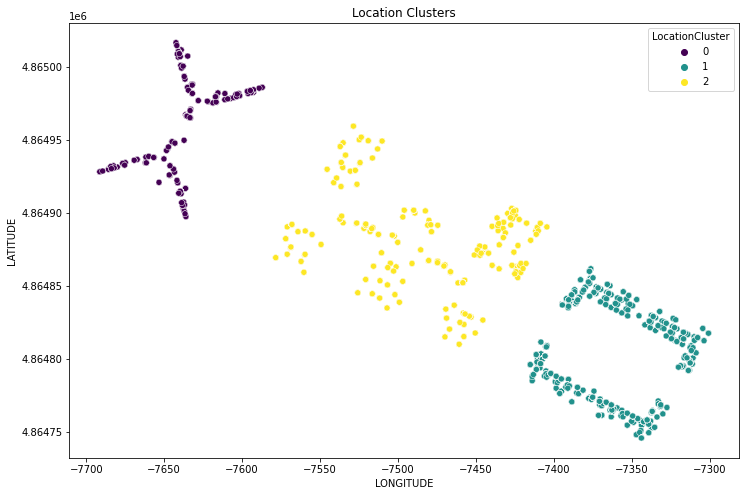

In [10]:
# Unsupervised Learning - K-Means Clustering
# Time Complexity: O(k * n * d * I * t)
# 3 location clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['LocationCluster'] = kmeans.fit_predict(df[['LATITUDE', 'LONGITUDE']])

# Visualize Location Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='LocationCluster', data=df, palette='viridis', legend='full')
plt.title('Location Clusters')
plt.show()

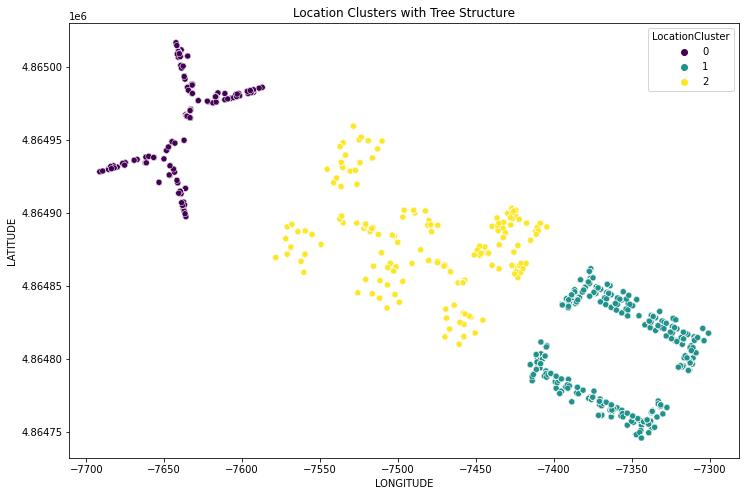

In [14]:
# Unsupervised Learning - K-Means Clustering
# Time Complexity: O(k * n * d * I * t)
# 3 location clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['LocationCluster'] = kmeans.fit_predict(df[['LATITUDE', 'LONGITUDE']])

# Use 'FLOOR' and 'SPACEID' for tree structure
# Hierarchical Structure - Tree Modeling for Location Clusters
df['LocationTreeStructure'] = df['FLOOR'].astype(str) + '_' + df['SPACEID'].astype(str)

# Visualize Location Clusters with Tree Structure
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='LocationCluster', data=df, palette='viridis', legend='full')
plt.title('Location Clusters with Tree Structure')
plt.show()


In [18]:
# Assuming 'LATITUDE' and 'LONGITUDE' are columns in your DataFrame
def sub_cluster(group):
    return KMeans(n_clusters=3).fit_predict(group[['LATITUDE', 'LONGITUDE']])

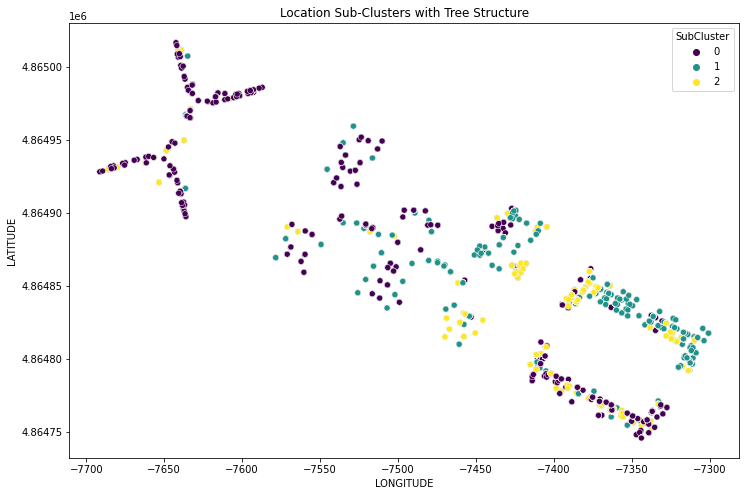

In [20]:
# Sub-Clustering - Create a new column for sub-cluster labels
sub_cluster_labels = Parallel(n_jobs=-1)(delayed(sub_cluster)(group) for _, group in df.groupby('LocationCluster'))

# Merge the sub-cluster labels back to the original DataFrame
df['SubCluster'] = np.concatenate(sub_cluster_labels).astype(int)

# Hierarchical Structure - Tree Modeling for SubClusters
df['SubClusterTreeStructure'] = df['FLOOR'].astype(str) + '_' + df['SPACEID'].astype(str)

# Visualize Location Sub-Clusters with Tree Structure
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='SubCluster', data=df, palette='viridis', legend='full')
plt.title('Location Sub-Clusters with Tree Structure')
plt.show()

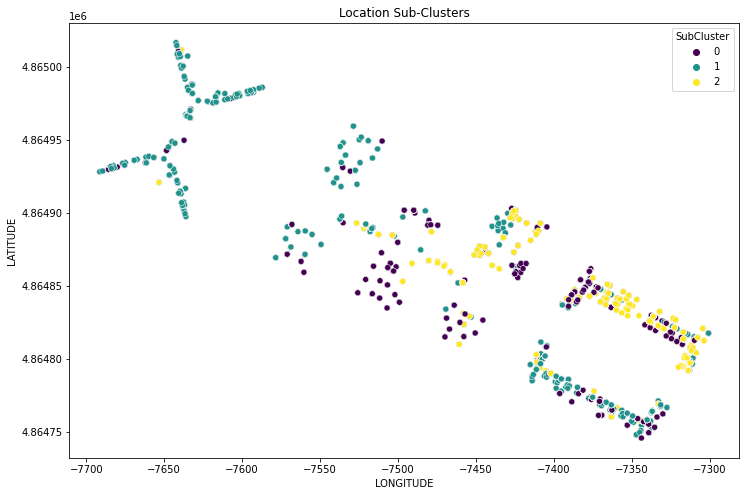

In [21]:
# Sub-Clustering - Create a new column for sub-cluster labels
sub_cluster_labels = Parallel(n_jobs=-1)(delayed(sub_cluster)(group) for _, group in df.groupby('LocationCluster'))

# Merge the sub-cluster labels back to the original DataFrame
df['SubCluster'] = np.concatenate(sub_cluster_labels).astype(int)

# Visualize Location Sub-Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='SubCluster', data=df, palette='viridis', legend='full')
plt.title('Location Sub-Clusters')
plt.show()

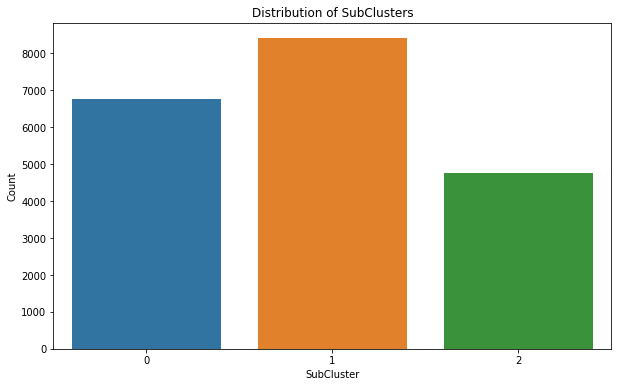

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='SubCluster', data=df)
plt.title('Distribution of SubClusters')
plt.xlabel('SubCluster')
plt.ylabel('Count')
plt.show()

### Supervised Learning
#### Random Forest

In [32]:
# Supervised Learning - Classification
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LocationCluster', 'SubCluster'], axis=1), df['SubCluster'], test_size=0.2, random_state=42)


# Random Forest Model Training
# Time Complexity: O(T * n * m * log(m) * I)
rf_model_1 = RandomForestClassifier(random_state=42)
rf_model_2 = RandomForestClassifier(random_state=42)
rf_model_3 = RandomForestClassifier(random_state=42)

# Impute missing values in 'SubCluster' with 0
df['SubCluster'].fillna(value=0, inplace=True)

In [33]:
# Random Forest - training models with different hyperparameters (GridSearch)
# Time Complexity: O(T * n * m * log(m) * I * g)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Best hyperparameters for Random Forest
best_rf_params = rf_grid_search.best_params_
print("Best Random Forest Hyperparameters:", best_rf_params)

# Train Random Forest with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

rf_model_1.fit(X_train, y_train)
rf_model_2.fit(X_train, y_train)
rf_model_3.fit(X_train, y_train)

# Evaluate each model
rf_pred_1 = rf_model_1.predict(X_test)
rf_pred_2 = rf_model_2.predict(X_test)
rf_pred_3 = rf_model_3.predict(X_test)

print("Random Forest Model 1 Classification Report:")
print(classification_report(y_test, rf_pred_1))
print("Random Forest Model 1 Accuracy:", accuracy_score(y_test, rf_pred_1))

print("Random Forest Model 2 Classification Report:")
print(classification_report(y_test, rf_pred_2))
print("Random Forest Model 2 Accuracy:", accuracy_score(y_test, rf_pred_2))

print("Random Forest Model 3 Classification Report:")
print(classification_report(y_test, rf_pred_3))
print("Random Forest Model 3 Accuracy:", accuracy_score(y_test, rf_pred_3))

Best Random Forest Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41      1383
           1       0.49      0.55      0.52      1689
           2       0.50      0.42      0.46       916

    accuracy                           0.47      3988
   macro avg       0.47      0.46      0.46      3988
weighted avg       0.47      0.47      0.47      3988

Random Forest Model 1 Accuracy: 0.47141424272818455
Random Forest Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41      1383
           1       0.49      0.55      0.52      1689
           2       0.50      0.42      0.46       916

    accuracy                           0.47      3988
   macro avg       0.47      0.46      0.46      3988
weighted avg       0.47      

#### Logistic Regression

In [37]:
# Logistic Regression
# Time Complexity: O(T * n * m * k * I)
lr_model_1 = LogisticRegression(random_state=42)
lr_model_2 = LogisticRegression(random_state=42)
lr_model_3 = LogisticRegression(random_state=42)

In [38]:
# Logistic Regression - training models with different hyperparameters (GridSearch)
# Time Complexity: O(T * n * m * k * I * g)
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

lr_grid_search = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid, cv=3, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)

# Best hyperparameters for Logistic Regression
best_lr_params = lr_grid_search.best_params_
print("Best Logistic Regression Hyperparameters:", best_lr_params)

# Train Logistic Regression with the best hyperparameters
best_lr_model = LogisticRegression(**best_lr_params, random_state=42)
best_lr_model.fit(X_train, y_train)

lr_model_1.fit(X_train, y_train)
lr_model_2.fit(X_train, y_train)
lr_model_3.fit(X_train, y_train)

# Evaluate each model
lr_pred_1 = lr_model_1.predict(X_test)
lr_pred_2 = lr_model_2.predict(X_test)
lr_pred_3 = lr_model_3.predict(X_test)

print("Logistic Regression Model 1 Classification Report:")
print(classification_report(y_test, lr_pred_1))
print("Logistic Regression Model 1 Accuracy:", accuracy_score(y_test, lr_pred_1))

print("Logistic Regression Model 2 Classification Report:")
print(classification_report(y_test, lr_pred_2))
print("Logistic Regression Model 2 Accuracy:", accuracy_score(y_test, lr_pred_2))

print("Logistic Regression Model 3 Classification Report:")
print(classification_report(y_test, lr_pred_3))
print("Logistic Regression Model 3 Accuracy:", accuracy_score(y_test, lr_pred_3))

c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\K1\AppData\Local\Programs\Python\Python310

Best Logistic Regression Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Logistic Regression Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1383
           1       0.42      1.00      0.60      1689
           2       0.00      0.00      0.00       916

    accuracy                           0.42      3988
   macro avg       0.14      0.33      0.20      3988
weighted avg       0.18      0.42      0.25      3988

Logistic Regression Model 1 Accuracy: 0.42352056168505514
Logistic Regression Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1383
           1       0.42      1.00      0.60      1689
           2       0.00      0.00      0.00       916

    accuracy                           0.42      3988
   macro avg       0.14      0.33      0.20      3988
weighted avg       0.18      0.42      0.25      3988

Logist

c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## Model Selection and Cross-Validation

In [39]:
# X is your feature matrix (excluding the target) and y is your target variable
X = df.drop(['SubCluster', 'LocationCluster'], axis=1)  # Adjust column names as needed
y = df['SubCluster']

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Random Forest Classifier
# Time Complexity: O(f * T * n * m * log(m) * I)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Random Forest Cross-Validation Scores:")
print(rf_cv_scores)
print("Mean Accuracy:", rf_cv_scores.mean())

Random Forest Cross-Validation Scores:
[0.47742947 0.48338558 0.47053292 0.4539185  0.47507056]
Mean Accuracy: 0.47206740254263535


In [42]:
# Logistic Regression
# Time Complexity: O(max_iter * T * n * m * k * I)
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("\nLogistic Regression Cross-Validation Scores:")
print(lr_cv_scores)
print("Mean Accuracy:", lr_cv_scores.mean())


Logistic Regression Cross-Validation Scores:
[0.42163009 0.42163009 0.42163009 0.42163009 0.42176231]
Mean Accuracy: 0.421656536821814


In [43]:
# Combine Models using VotingClassifier
# Time Complexity: O(f * T * n * m * k * I)
voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('lr', lr_classifier)], voting='hard')
ensemble_cv_scores = cross_val_score(voting_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("\nEnsemble (Voting) Cross-Validation Scores:")
print(ensemble_cv_scores)
print("Mean Accuracy:", ensemble_cv_scores.mean())



Ensemble (Voting) Cross-Validation Scores:
[0.43040752 0.42884013 0.42633229 0.41598746 0.42238946]
Mean Accuracy: 0.42479137238017445


In [44]:
# Fit the ensemble model on the full training set
# Time Complexity: O(f * T)
voting_classifier.fit(X_train, y_train)

# Evaluate on the test set
# Time Complexity: O(f * T * n * m * k * I)
test_accuracy = voting_classifier.score(X_test, y_test)
print("\nEnsemble (Voting) Test Accuracy:", test_accuracy)


Ensemble (Voting) Test Accuracy: 0.42753259779338015


## Prediction

In [45]:
# Fit the ensemble model on the full training set
voting_classifier.fit(X_train, y_train)

# Evaluate on the test set
test_predictions = voting_classifier.predict(X_test)
test_accuracy = voting_classifier.score(X_test, y_test)

# Classification Report
classification_rep = classification_report(y_test, test_predictions)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.40      0.41      1383
           1       0.43      0.68      0.53      1689
           2       0.00      0.00      0.00       916

    accuracy                           0.43      3988
   macro avg       0.28      0.36      0.31      3988
weighted avg       0.33      0.43      0.37      3988



c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier